In [1]:
# !pip install pandas matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import io
import re

In [3]:
df = pd.concat((
    pd.read_csv(f)
    for f in [
        './data/ble-dump/52hz/4g-500dps/circle-rot-inv.csv',
        './data/ble-dump/52hz/4g-500dps/L-rot-inv.csv',
        './data/ble-dump/52hz/4g-500dps/X-rot-inv.csv',
    ]
))
# Shortcut.
df['r'] = df['initial_row_angle']
df

,ax,ay,az,gx,gy,gz,name,n,initial_row_angle,r
0,8218,599,9025,-2366,-150,-576,circle,0,0.214708,0.214708
1,9079,105,14757,-2795,509,-2108,circle,0,0.214708,0.214708
2,8416,-833,18242,-1938,450,-4052,circle,0,0.214708,0.214708
3,6703,-2384,20087,-342,-135,-6042,circle,0,0.214708,0.214708
4,2226,-3342,20005,1532,-149,-8045,circle,0,0.214708,0.214708
...,...,...,...,...,...,...,...,...,...,...
790,874,-2589,16456,3331,593,-2388,X,10,0.305303,0.305303
791,-780,-3122,13942,4338,1005,-2758,X,10,0.305303,0.305303
792,-1802,-3415,10901,5056,1023,-2811,X,10,0.305303,0.305303
793,-2434,-3308,7123,5342,539,-2687,X,10,0.305303,0.305303


In [12]:
def plot_mov(df, name, n, ax):
    df[
        (df.name == name) & (df.n == n)
    ][['ax', 'ay', 'az', 'gx', 'gy', 'gz']].plot(ax=ax)
    ax.set_title(f'{name} #{n}')
    ax.legend(bbox_to_anchor=(1.0, 1.0))

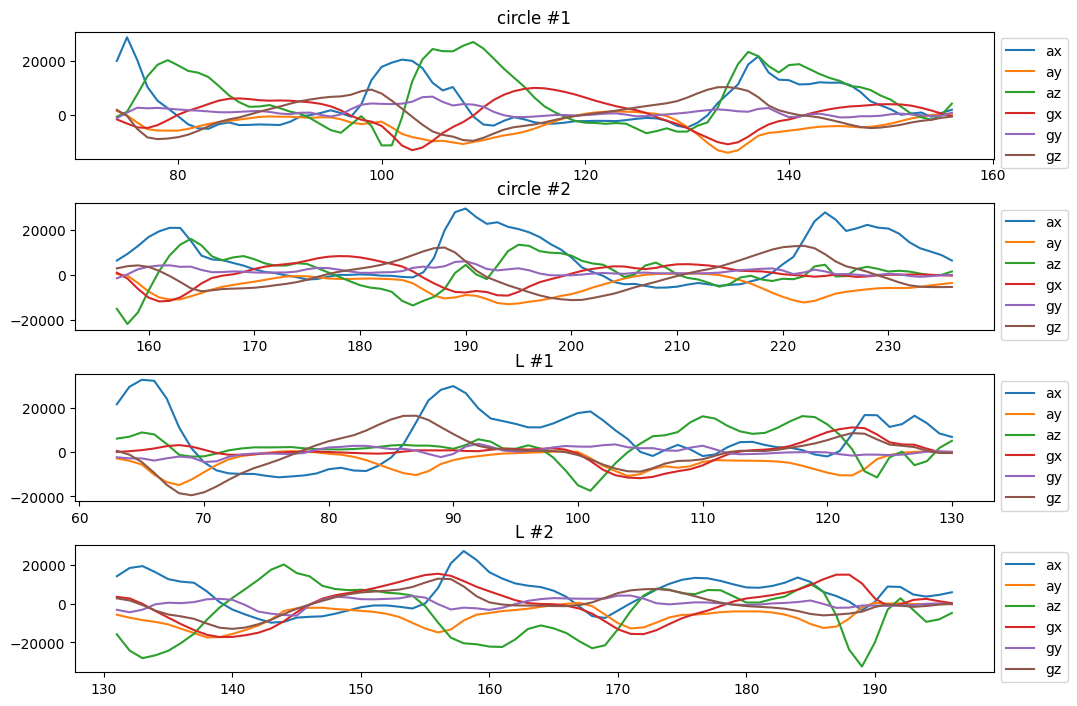

In [16]:
N_EACH = 2

fig, axs = plt.subplots(2 * N_EACH, 1, figsize=(10, 7))
fig.tight_layout()

for i in range(N_EACH):
    plot_mov(df, 'circle', i+1, axs[i])

for i in range(N_EACH):
    plot_mov(df, 'L', i+1, axs[i + N_EACH])



In [139]:
#!pip install dtw-python
# !pip install seaborn dtw-python

In [140]:
import dtw

# https://dynamictimewarping.github.io/python/

Text(0, 0.5, 'circle #4')

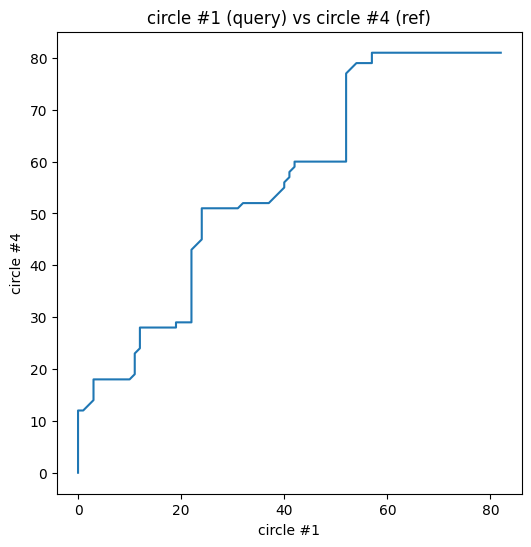

In [141]:
DATA_COLS = ['ax', 'ay', 'az', 'gx', 'gy', 'gz']
# DATA_COLS = ['ax', 'ay', 'az']

def mov_df(df, name, n):
    return df[(df.name == name) & (df.n == n)][DATA_COLS]

res = dtw.dtw(
    # Query.
    mov_df(df, 'circle', 1),
    # Reference.
    mov_df(df, 'circle', 4)
)
ax = res.plot()
ax.set_title('circle #1 (query) vs circle #4 (ref)')
ax.set_xlabel('circle #1')
ax.set_ylabel('circle #4')

Text(0, 0.5, 'circle #4')

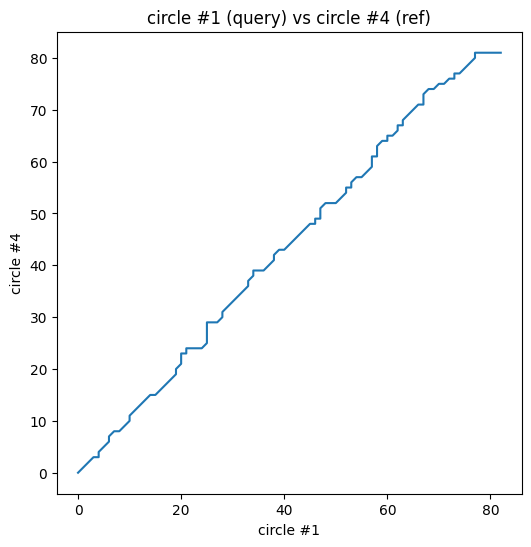

In [142]:
import math
proj_df = df.copy(deep=True)
proj_df['az'] = df['az'] * np.cos(df['r']) - df['ax'] * np.sin(df['r'])
proj_df['ax'] = df['az'] * np.sin(df['r']) + df['ax'] * np.cos(df['r'])
proj_df['gz'] = df['gz'] * np.cos(df['r']) - df['gx'] * np.sin(df['r'])
proj_df['gx'] = df['gz'] * np.sin(df['r']) + df['gx'] * np.cos(df['r'])
# proj_df['ax'] = np.sin(df['az']) + np.cos(df['ax'])
# proj_df['gz'] = np.cos(df['gz']) + np.sin(df['gx'])
# proj_df['gx'] = np.sin(df['gz']) + np.cos(df['gx'])

res = dtw.dtw(
    # Query.
    mov_df(proj_df, 'circle', 1),
    # Reference.
    mov_df(proj_df, 'circle', 4)
)
ax = res.plot()
ax.set_title('circle #1 (query) vs circle #4 (ref)')
ax.set_xlabel('circle #1')
ax.set_ylabel('circle #4')

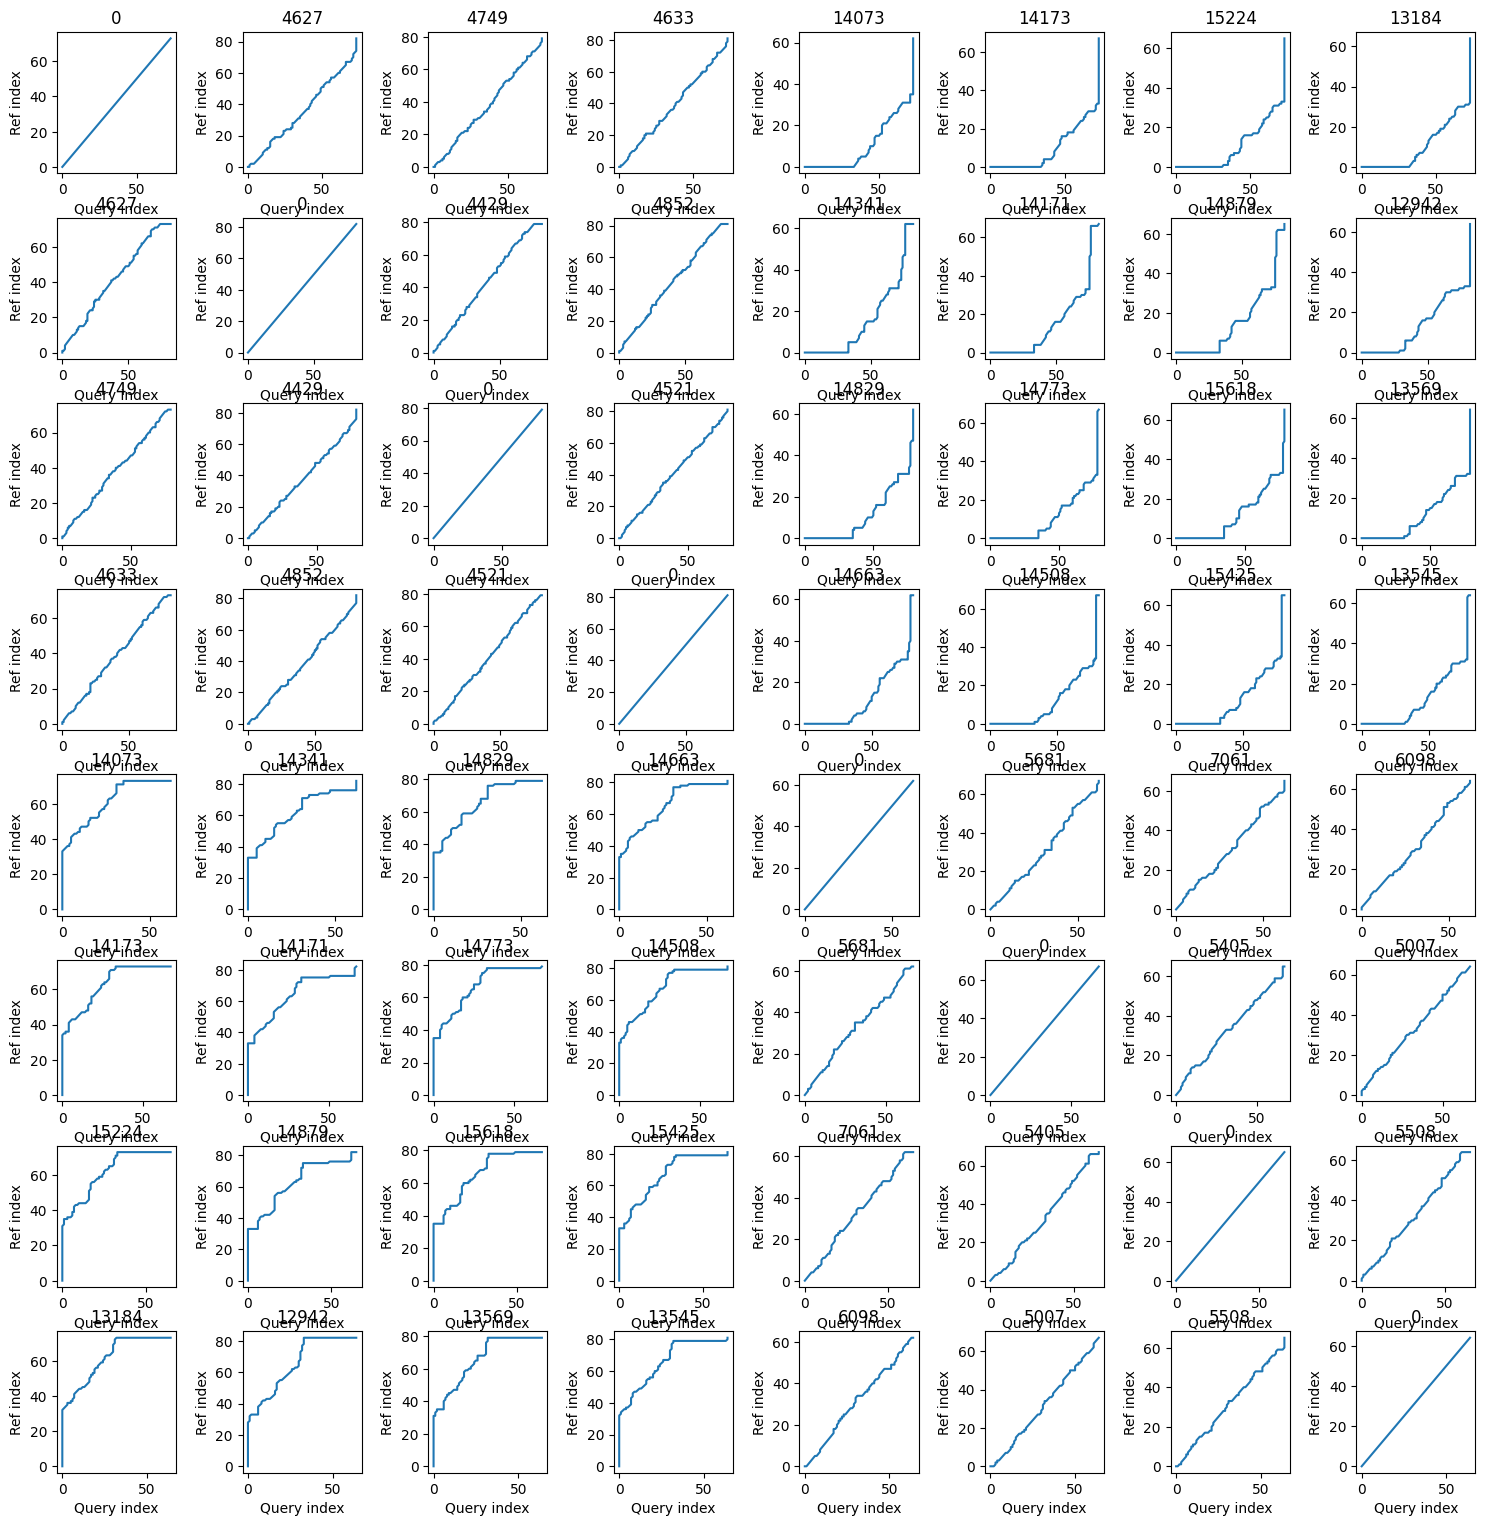

In [143]:
dfs = [mov_df(proj_df, 'circle', i) for i in range(4)] + \
      [mov_df(proj_df, 'L', i) for i in range(4)]



fig, axs = plt.subplots(len(dfs), len(dfs), figsize=(15, 15))
fig.tight_layout()
for i, df1 in enumerate(dfs):
    for j, df2 in enumerate(dfs):
        ax = axs[i][j]
        align = dtw.dtw(df1, df2) 
        # try:
        #     align = dtw.dtw(df1, df2, window_type="sakoechiba", window_args={'window_size': 20})
        # except ValueError:
        #     continue
        # https://github.com/DynamicTimeWarping/dtw-python/blob/56d2e09dd4409f2d7bafb465889d696a25ebdd2c/dtw/dtwPlot.py#L79
        ax.plot(align.index1, align.index2)
        ax.set_xlabel("Query index")
        ax.set_ylabel("Ref index")
        ax.set_title(f'{int(align.normalizedDistance)}')

In [144]:
import itertools

keys = [k for k, v in df.groupby(['name', 'n'])]

def k_dist(k1, k2):
    return dtw.dtw(mov_df(proj_df, *k1), mov_df(proj_df, *k2)).normalizedDistance
    # try:
    #     return dtw.dtw(mov_df(df, *k1), mov_df(df, *k2), window_type="sakoechiba", window_args={'window_size': 20}).normalizedDistance
    # except ValueError as e:
    #     return 20e3

def name(k):
    s, n = k
    return f'{s}_{n}'

records = [{
    'k1': name(k1),
    'k2': name(k2),
    'same_gesture': k1[0] == k2[0],
    'dist': k_dist(k1, k2),
    }
    for a, b in itertools.combinations_with_replacement(keys, 2)
    for k1, k2 in [(a, b), (b, a)]
    if k1 != k2
]

dist_matrix = pd.DataFrame.from_records(records)

In [145]:
dist_df = dist_matrix.pivot(index='k1', columns='k2', values='dist').fillna(0.0)

<Axes: xlabel='k2', ylabel='k1'>

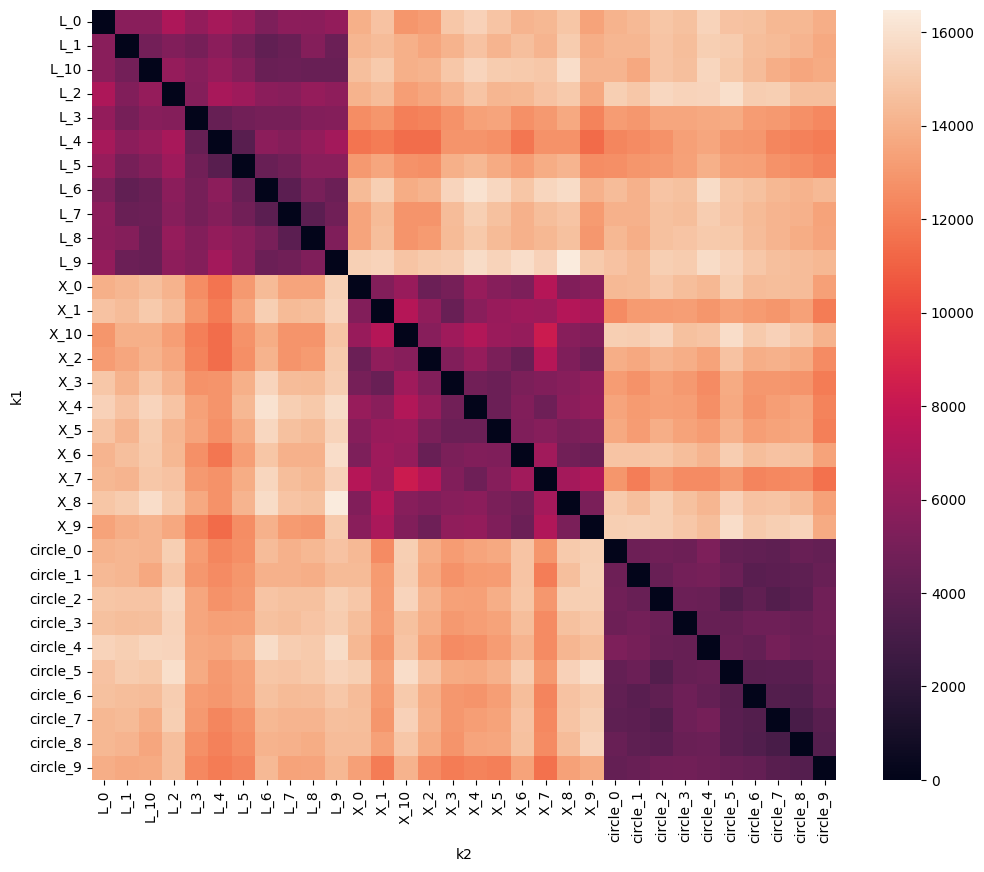

In [146]:
import seaborn as sns

fig, ax = plt.subplots(1, 1, figsize=(12,10))
sns.heatmap(dist_df, ax=ax)

In [147]:
# Which row is the min dist to circle_0?
dist_df.columns[dist_df['circle_0'].argmin()]

'circle_0'

same_gesture
False    [[Axes(0.125,0.11;0.775x0.77)]]
True     [[Axes(0.125,0.11;0.775x0.77)]]
dtype: object

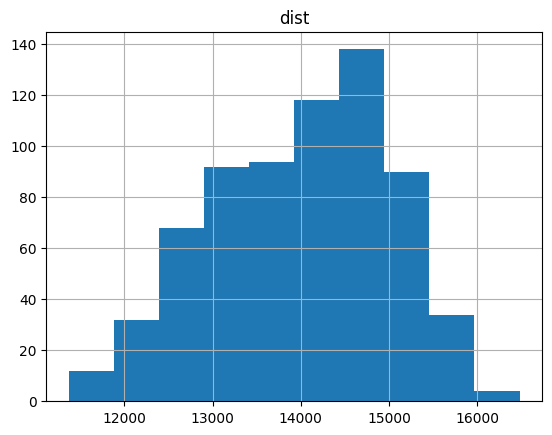

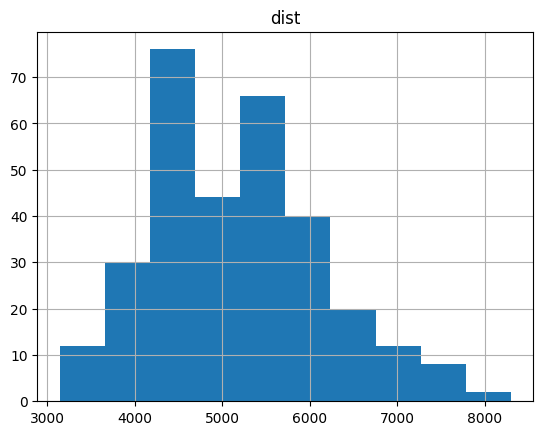

In [148]:
dist_matrix.groupby('same_gesture').hist('dist')